<a href="https://colab.research.google.com/github/eccardoso/ML/blob/main/MVP_ML_Regressao_Produ%C3%A7%C3%A3o_Leite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MVP de Machine Learning

Edson da Costa Cardoso

###MVP - Predição de produção e escolha de cruzamentos para cabras leiteiras

### **1. Definição do Problema**

Em produção de pequenos ruminantes (cabras e ovelhas) existe uma dificuldade muito grande em se ter uma técnica para escolha de cruzamentos e precificação de cabritas/borregas ao nascer. As "estimativas" atuais se baseiam em feeling a partir de dados determinísticos.

### **2. Solução**

Após análise do problema foi mapeada uma solução onde a medição do controle leiteiro (saída-numérica) e os dados de entrada do controle pudessem gerar um resultado preditivo de produção usando uma técnica de aprendizado supervisionado com algoritmos de ML para regresão.

A escolha das variáveis com maior impacto em uma produção leiteira foram definidas em conjunto com veterinário e zootecnista da UFMG.

O conjunto de dados do Controle Leiteiro (medição de leite por cabra) realizado mensalmente desde 2020 foi utlizado como o dataset para o modelo.

Estes dados foram coletados de uma criação de cabras em MG no qual sou o proprietário e desenvolvedor das soluções de software de coletas de dados utilizadas. A propriedade tem como foco a produção de leite e seu beneficiamento.

**O dataset contém as seguintes variáveis numéricas:**

Brinco_Pai=Identificação do pai da cabra em lactação

Brinco_Mae=Identificação da mãe da cabra em lactação

Brinco_Animal=Identificação da cabra ordenhada

Media_pai=Media de produção de leite transmitida para todas as filhas

Media_mae=Media de produção de leite da mãe

Media_prod=Media de produção do animal ordenhado no controle

Idade=Idade da cabra em lactação

Ordem_Lac=Oderm da lactação (primeira lactação, segunda lactação, etc)

DEL=Dias em lactação desde o início da parição

Prod_Leit=Produção de leite (saída)

In [258]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports das bibliotecas necessárias para programação
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.ensemble import BaggingRegressor # algoritmo Bagging
from sklearn.ensemble import RandomForestRegressor # algoritmo Random Forest
from sklearn.ensemble import ExtraTreesRegressor # algoritmo Extra Trees
from sklearn.tree import DecisionTreeRegressor  #algoritmo Decision Tree Regressor
from sklearn.ensemble import AdaBoostRegressor # algoritmo AdaBoost
from sklearn.ensemble import GradientBoostingRegressor # algoritmo GradientBoost
from sklearn.ensemble import AdaBoostRegressor # algoritmo KNN
from sklearn.ensemble import VotingRegressor # algoritmo Voting
from sklearn.svm import SVR # algoritmo SVM
from sklearn.metrics import accuracy_score

#**3. Carga e Preparação do Dataset**

Para carregar o arquivo .csv, foi utilizado o pacote Pandas (Python Data Analysis Library).

In [259]:
# Carga do dataset

# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/eccardoso/ML/main/BASE_ML_v4.csv"

# Lê o arquivo
datasetori = pd.read_csv(url, delimiter=';')

# Converte as variaveis para float
datasetori["Media_Mae"]=pd.to_numeric(datasetori["Media_Mae"],errors='coerce')
datasetori["Prod_Leit"]=pd.to_numeric(datasetori["Prod_Leit"],errors='coerce')

# Eliminando colunas não relevantes para análise
dataset=datasetori.drop(['Brinco_Pai','Brinco_Mae','Brinco_Animal'],axis='columns')

# Tabela com as medidas descritivas das variáveis numéricas do dataset.
dataset.describe()

,Media_Pai,Media_Mae,Idade,Ordem_Lac,DEL,Prod_Leit
count,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000
mean,1.601317,1.468635,2.983234,1.471856,160.904192,1.756946
std,0.121766,0.566094,1.230003,0.657085,118.447290,0.878162
min,1.310000,0.600000,1.000000,1.000000,1.000000,0.100000
25%,1.460000,1.090000,2.000000,1.000000,72.500000,1.150000
50%,1.660000,1.370000,3.000000,1.000000,148.000000,1.600000
75%,1.660000,1.870000,4.000000,2.000000,229.500000,2.300000
max,1.760000,2.900000,7.000000,4.000000,913.000000,5.000000


#**4. Avaliando a correlação das variáveis**

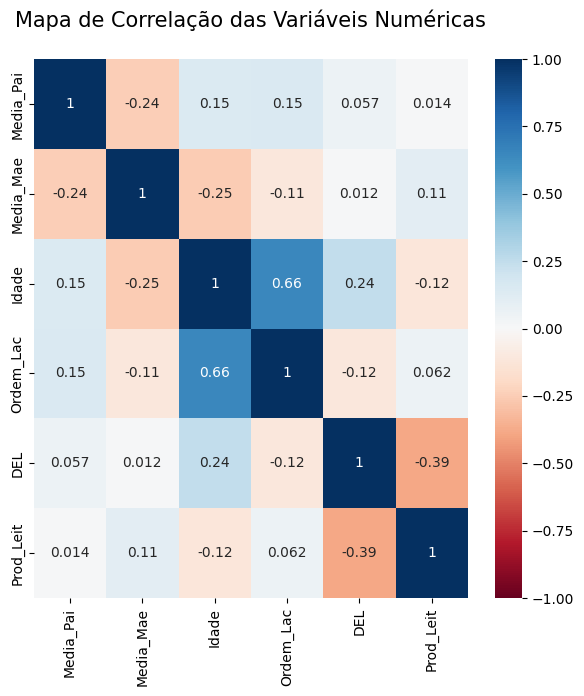

In [260]:
# Heatmap
plt.figure(figsize = (7,7))
sns.heatmap(dataset.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);
plt.title("Mapa de Correlação das Variáveis Numéricas\n", fontsize = 15)
plt.show()

#**5. Separação em conjunto de treino e conjunto de teste**

In [261]:
# Preparação dos dados

# Separação em bases de treino e teste (holdout)
array = dataset.values
X = array[:,0:5] # atributos
y = array[:,5] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão
scoring = 'accuracy'
# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

#**6. Criação e avaliação de modelos: linha base**

LR: MSE 0.65 (0.14) - RMSE 0.80
Ridge: MSE 0.65 (0.14) - RMSE 0.80
Lasso: MSE 0.66 (0.15) - RMSE 0.81
KNN: MSE 0.72 (0.14) - RMSE 0.85
CART: MSE 1.00 (0.26) - RMSE 1.00
SVR: MSE 0.63 (0.14) - RMSE 0.79
Bagging: MSE 0.51 (0.11) - RMSE 0.71
RF: MSE 0.49 (0.11) - RMSE 0.70
ET: MSE 0.50 (0.12) - RMSE 0.71
Ada: MSE 0.60 (0.14) - RMSE 0.78
GB: MSE 0.54 (0.13) - RMSE 0.73
Voting: MSE 0.59 (0.16) - RMSE 0.77


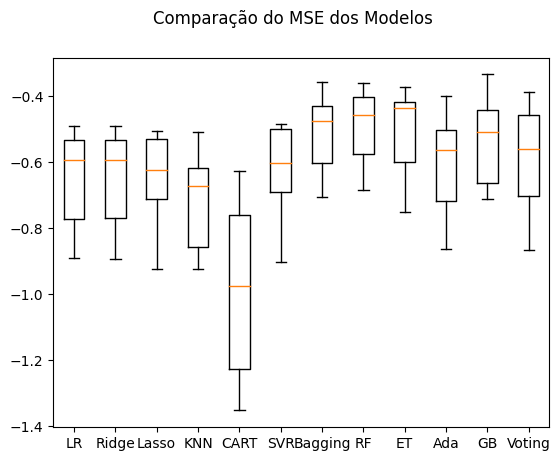

In [262]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeRegressor()
num_trees = 1000
max_features = 3

bases = []
model1 = LinearRegression()
bases.append(('logistic', model1))
model2 = DecisionTreeRegressor()
bases.append(('cart', model2))
model3 = SVR()
bases.append(('svm', model3))

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingRegressor(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostRegressor(n_estimators=num_trees)))
models.append(('GB', GradientBoostingRegressor(n_estimators=num_trees)))
models.append(('Voting', VotingRegressor(bases)))


# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#**7. Criação e avaliação de modelos: dados padronizados e normalizados**

LR-orig: MSE 0.65 (0.14) - RMSE 0.80
RIDG-orig: MSE 0.65 (0.14) - RMSE 0.80
LAS-orig: MSE 0.66 (0.15) - RMSE 0.81
KNN-orig: MSE 0.72 (0.14) - RMSE 0.85
CART-orig: MSE 1.00 (0.26) - RMSE 1.00
SVR-orig: MSE 0.63 (0.14) - RMSE 0.79
Bag-orig: MSE 0.51 (0.11) - RMSE 0.71
RF-orig: MSE 0.49 (0.11) - RMSE 0.70
ET-orig: MSE 0.50 (0.12) - RMSE 0.71
Ada-orig: MSE 0.60 (0.14) - RMSE 0.78
GB-orig: MSE 0.54 (0.13) - RMSE 0.73
Vot-orig: MSE 0.59 (0.16) - RMSE 0.77
LR-padr: MSE 0.65 (0.14) - RMSE 0.80
RIDG-padr: MSE 0.65 (0.14) - RMSE 0.80
LAS-padr: MSE 0.76 (0.14) - RMSE 0.87
KNN-padr: MSE 0.62 (0.15) - RMSE 0.79
CART-padr: MSE 0.98 (0.25) - RMSE 0.99
SVR-padr: MSE 0.56 (0.14) - RMSE 0.75
Bag-padr: MSE 0.51 (0.11) - RMSE 0.71
RF-padr: MSE 0.49 (0.10) - RMSE 0.70
ET-padr: MSE 0.51 (0.12) - RMSE 0.71
Ada-padr: MSE 0.59 (0.13) - RMSE 0.77
GB-padr: MSE 0.54 (0.14) - RMSE 0.73
Vot-padr: MSE 0.57 (0.17) - RMSE 0.75
LR-norm: MSE 0.65 (0.14) - RMSE 0.80
RIDG-norm: MSE 0.65 (0.14) - RMSE 0.81
LAS-norm: MSE 0.

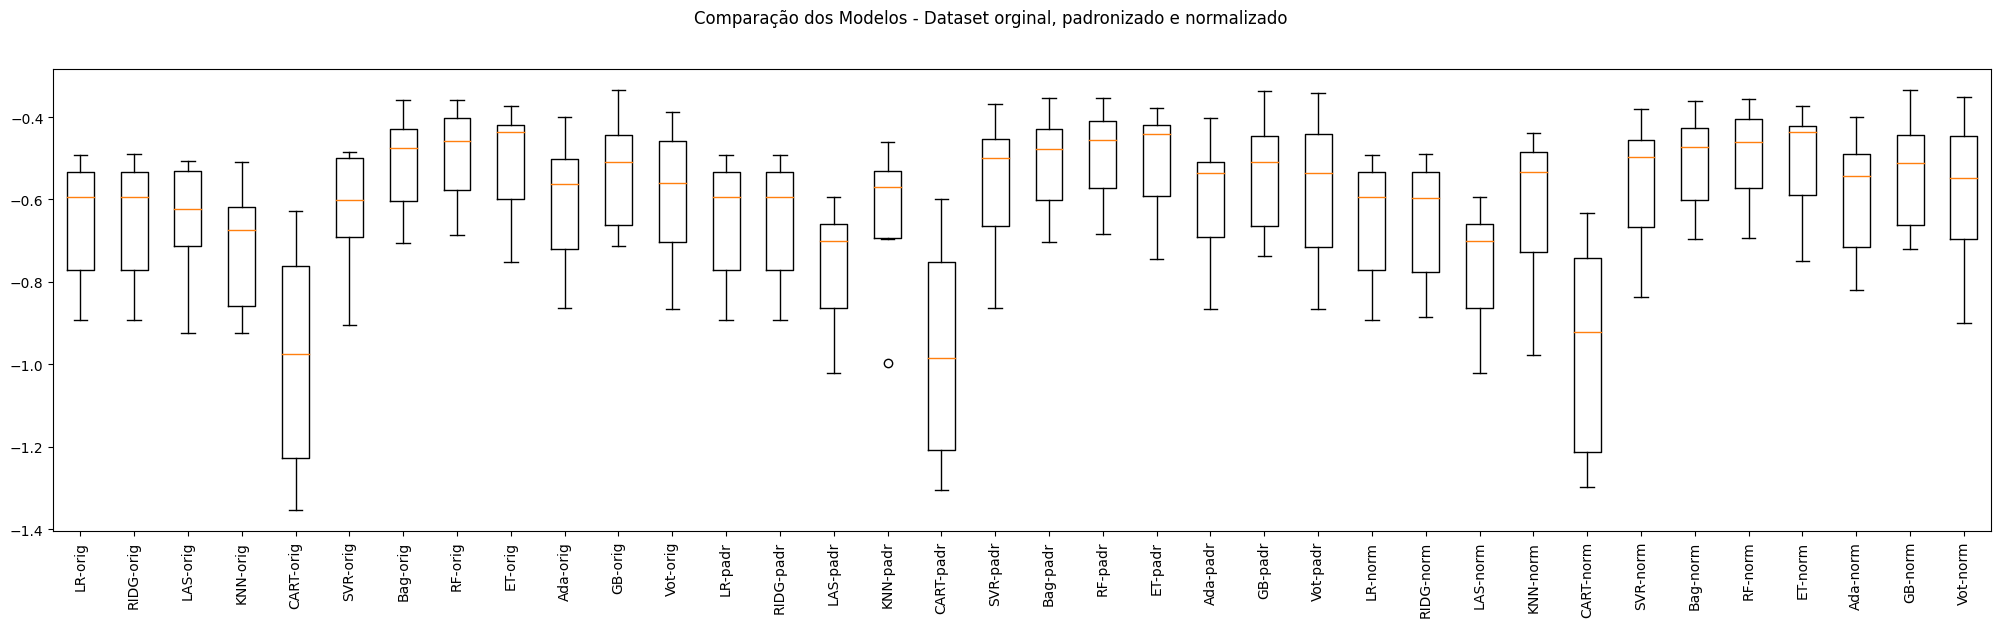

In [263]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LinearRegression())
ridg=('Ridge', Ridge())
las=('Lasso', Lasso())
knn = ('KNN', KNeighborsRegressor())
cart = ('CART', DecisionTreeRegressor())
svm = ('SVR', SVR())
bagging = ('Bag', BaggingRegressor(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostRegressor(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingRegressor(n_estimators=num_trees))
voting = ('Voting', VotingRegressor(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('RIDG-orig', Pipeline([ridg])))
pipelines.append(('LAS-orig', Pipeline([las])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVR-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('RIDG-padr', Pipeline([standard_scaler,ridg])))
pipelines.append(('LAS-padr', Pipeline([standard_scaler,las])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVR-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('RIDG-norm', Pipeline([min_max_scaler,ridg])))
pipelines.append(('LAS-norm', Pipeline([min_max_scaler,las])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVR-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

#**8. Escolha do modelo**

Os modelos com menores MSE foram testados sendo os melhores resultados obtidos com o Random Forest e Gradient Boosting variando o número de árvores, porém o modelo com maior acurácia foi o Gradient Boosting padronizado com n_estimators=1000

In [264]:
# Criando um modelo com todo o conjunto de treino

model=Pipeline([standard_scaler, gradient_boosting])
model.fit(X_train, y_train)
r_squared = model.score(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# Estimando o MSE, RMSE, RD, MAE e MAPE no conjunto de teste e valiação
mse = mean_squared_error(y_test, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))
print("RS %0.2f" %r_squared)

error=mae(y_test,predictions)
print ("MAE %0.2f" % error)

error=mape(y_test,predictions)
acuracia=100-(error*100)
print ("ACURACIA %0.2f" % acuracia)

MSE 0.52
RMSE 0.72
RS 0.94
MAE 0.56
ACURACIA 45.88


In [265]:
# Preparação do modelo com TODO o dataset
model.fit(X, y)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('GB', GradientBoostingRegressor(n_estimators=1000))])

#**9. Execução do modelo com dados não vistos**

Avaliação do modelo utilizando como base dados do controle leiteiro realizado e não utlizado no treinamento e teste do modelo

In [266]:
# Dados reais da saída do controle leiteiro -> (1.5) (0.9) (1.5)  (1.1) para os dados de entrada abaixo

data = {'Media_Pai': [1.66,1.76,1.58,1.66],
        'Media_Mae': [1.37,1.2,1.69,0.74],
        'Idade':[4,5,3,3],
        'Ordem_Lac': [1,2,2,2],
        'DEL':[765,491,114,311]
        }

atributos = ['Media_Pai','Media_Mae','Idade','Ordem_Lac','DEL']
entrada = pd.DataFrame(data, columns=atributos)

X_entrada=entrada.values

# Verificar a carga dos dados
print(entrada)


   Media_Pai  Media_Mae  Idade  Ordem_Lac  DEL
0       1.66       1.37      4          1  765
1       1.76       1.20      5          2  491
2       1.58       1.69      3          2  114
3       1.66       0.74      3          2  311


#**10. Saída do modelo com os dados de entrada**

In [267]:
# Predição do volume produzido
saidas = model.predict(X_entrada)
print(saidas)

[1.43167    1.05068768 2.41813135 1.27970805]


#**11. Avaliação dos erros resultado real x saída do modelo**

In [268]:
# Estimando os erros no conjunto simulado
real=[1.5,0.9,1.5,1.1]
mse = mean_squared_error(real, saidas)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))
print("RS %0.2f" %r_squared)

error=mae(real,saidas)
print ("MAE %0.2f" % error)

error=mape(real,saidas)
acuracia=100-(error*100)
print ("ACURACIA %0.2f" % acuracia)


MSE 0.23
RMSE 0.48
RS 0.94
MAE 0.33
ACURACIA 75.29


#**12. Conclusão**

O comportamento do modelo baseado nas diversas métricas de erros analisados durante a simulação teve uma  acurácia de mais de 75% na predição ao analisar o MAPE (Erro Médio Absoluto Percentual). O MAPE foi escolhido  por ser mais fácil a interpretação.

Apesar do erro ser aceitável pelo nicho de negócio seria necessário um estudo mais profundo para melhoria do modelo uma vez que existem situações não previstas como um animal ter uma doença antes do Controle Leiteiro, troca da alimentação consumida etc que podem afetar sua produtividade e provocar outliers afetando a acurácia do modelo.

Outro ponto a considerar é que variáveis como peso ao nascer e peso ao desmame podem ser adicionados ao modelo para diferenciar animais que nasceram da mesma mãe quando for realizada a previsão de produção entre irmãs, porém estes dados não estavam disponíveis no dataset mas serão coletados para melhoria do modelo.

Ressalta-se que o contexto problemático é bastante complexo requerendo sugestões de estudiosos da área, mas este MVP já apoia o direcionamento do produtor que hoje se encontra míope.